In [5]:
# -- Bib
import os
import sys
sys.path.append("..")

import glob
from pathlib import Path
import networkx as nx
import geopandas as gpd
import pandas as pd
import datetime as dt
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiPolygon, Polygon
from dateutil.relativedelta import relativedelta
import mapclassify
from collections import defaultdict
from scipy.stats import linregress

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle

idx = pd.IndexSlice

# -- base paths
basepath = Path.home().joinpath("Documents", "data")
cnespath = basepath.joinpath("opendatasus", "cnes")
geopath = basepath.joinpath("shapefilesceqgis")
simpath = basepath.joinpath("sim", "DBF")
gmlpath = basepath.joinpath("redes_aih")
ccapath = basepath.joinpath("cca_erneson")
figpath = gmlpath.joinpath("doc_final")

# -- load geo
geodata_df = gpd.read_parquet(geopath.joinpath("ce_geodata.parquet"))
ce_geodata_df = gpd.read_parquet(geopath.joinpath("ce_regiao_saude_municipios.parquet"))

setor_df = gpd.read_file(geopath.joinpath("CE_Malha_Preliminar_2022", "CE_Malha_Preliminar_2022.shp"))
setor_df["GEOCOD6"] = setor_df["CD_MUN"].apply(lambda x: x[:6])

In [9]:
# -- load geo
geodata_df1 = ce_geodata_df.copy()

# -- create the two datasets
# -- one: geolocation of health units who genereated an AIH during 2018-2023 (this period can be flexible)
# -- two: geolocation of census units with the number of population contained in each unit
cnes_df = pd.read_parquet(os.path.join(cnespath, "cnes_st_0801_2312.parquet"))
cnes_df = cnes_df[["CNES", "CODUFMUN", "latitude", "longitude"]]
cnes_df = cnes_df.merge(geodata_df1[["GEOCOD6", "MACRO_ID", "REGIAO_SAUDE_8", "REGIAO_SAUDE_9", "REGIAO_SAUDE_10"]], left_on="CODUFMUN", right_on="GEOCOD6", how="left").drop("GEOCOD6", axis=1)

pop_census_df = gpd.read_parquet(os.path.join(geopath, "censo2010_pop_setores.parquet"))
pop_census_df1 = pop_census_df[["CD_GEOCODI", "CD_GEOCODM", "geometry", "Pop_setor_censo2010"]].copy()
pop_census_df1["GEOCOD6"] = pop_census_df1["CD_GEOCODM"].apply(lambda x: x[:6])
pop_census_df1 = pop_census_df1.merge(geodata_df1[["GEOCOD6", "MACRO_ID", "REGIAO_SAUDE_8", "REGIAO_SAUDE_9", "REGIAO_SAUDE_10"]], on="GEOCOD6", how="left")
pop_census_df1['centroid'] = pop_census_df1['geometry'].centroid
pop_census_df1 = pop_census_df1.drop('geometry', axis=1).rename({'centroid': 'geometry'}, axis=1).set_geometry('geometry')
pop_census_df1 = pop_census_df1.to_crs(epsg=29194).copy()

# -- the city-hospital bipartite network can provide which health units are actually relevant for analysis (generated at least one AIH during the period chosen)
graph = nx.read_gml(os.path.join(gmlpath, "novo_completo", "citytohospitalnet_agg_1801_2306.gml"))

# -- filter only the relevant health units
valid_cnes = [ graph.nodes[v]['code'] for v in graph.nodes() if graph.nodes[v]['type']=='hospital' and graph.degree(v)>0 ]
valid_cnes_df = cnes_df[cnes_df["CNES"].isin(valid_cnes)]

# -- define the geometry of the health units
valid_cnes_df["geometry"] = gpd.points_from_xy(valid_cnes_df.longitude, valid_cnes_df.latitude)
valid_cnes_df = gpd.GeoDataFrame(valid_cnes_df, geometry='geometry', crs="EPSG:4674")
# -- health units in projection for meters
valid_cnes_df1 = valid_cnes_df.to_crs(epsg=29194).copy()
#valid_cnes_df1 = valid_cnes_df.copy()

C:\Users\higor.monteiro\AppData\Local\Temp\ipykernel_20640\2743335845.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pop_census_df1['centroid'] = pop_census_df1['geometry'].centroid
C:\Users\higor.monteiro\AppData\Local\Temp\ipykernel_20640\2743335845.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_cnes_df["geometry"] = gpd.points_from_xy(valid_cnes_df.longitude, valid_cnes_df.latitude)


In [10]:
# ORIGINAL
def get_distances_macro(macro_id, valid_cnes_df, pop_setor, macro_col="MACRO_ID"):
    '''
        does not consider the population of setor
    '''
    subset_cnes = valid_cnes_df1[valid_cnes_df[macro_col]==macro_id]
    subset_pop_setor = pop_setor[pop_setor[macro_col]==macro_id]
                                 
    #macro_distances = []
    #for index in range(subset_cnes.shape[0]):
    #    current_point_cnes = subset_cnes.geometry.iloc[index]
    #    lst_dist = (subset_pop_setor.distance(current_point_cnes)/1000)*subset_pop_setor["Pop_setor_censo2010"].apply(lambda x: np.ones(int(x)) if pd.notna(x) else np.array([]))
    #    macro_distances += lst_dist.apply(list).sum()

    macro_distances = subset_cnes.geometry.apply(lambda g: subset_pop_setor.distance(g)/1000).values.flatten() # km
    return macro_distances

def get_pop_weighted_distances_macro(macro_id, valid_cnes_df, pop_setor, macro_col="MACRO_ID", quantile=0.10):
    '''

    '''
    subset_cnes = valid_cnes_df[valid_cnes_df[macro_col]==macro_id]
    subset_pop_setor = pop_setor[pop_setor[macro_col]==macro_id]

    weighted_distances = []
    for index in range(subset_cnes.shape[0]):
        current_point_cnes = subset_cnes.geometry.iloc[index]
        arr = subset_pop_setor.distance(current_point_cnes)/1000
        arr1 = arr[arr<=arr.quantile(quantile)]
        res = arr1.apply(lambda x: [x] if pd.notna(x) else np.nan)*subset_pop_setor["Pop_setor_censo2010"].loc[arr1.index].fillna(0).astype(int)

        #res = (subset_pop_setor.distance(current_point_cnes)/1000).apply(lambda x: [x] if pd.notna(x) else np.nan)*subset_pop_setor["Pop_setor_censo2010"].fillna(0).astype(int)
        weighted_distances.append(res)

    weighted_distances = pd.concat(weighted_distances)
    base_dist = []
    for lst in weighted_distances.values:
        base_dist += lst
    return base_dist

macrodist1 = get_pop_weighted_distances_macro(1, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID")
macrodist2 = get_pop_weighted_distances_macro(2, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID")
macrodist3 = get_pop_weighted_distances_macro(3, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID")
macrodist4 = get_pop_weighted_distances_macro(4, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID")
macrodist5 = get_pop_weighted_distances_macro(5, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="MACRO_ID")

# -- OITO REGIÕES
macrodist1_prop = get_pop_weighted_distances_macro(1, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_8")
macrodist2_prop = get_pop_weighted_distances_macro(2, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_8")
macrodist3_prop = get_pop_weighted_distances_macro(3, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_8")
macrodist4_prop = get_pop_weighted_distances_macro(4, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_8")
macrodist5_prop = get_pop_weighted_distances_macro(5, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_8")
macrodist6_prop = get_pop_weighted_distances_macro(6, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_8")
macrodist7_prop = get_pop_weighted_distances_macro(7, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_8")
macrodist8_prop = get_pop_weighted_distances_macro(8, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_8")

# -- DEZ REGIÕES
macrodist1_prop9 = get_pop_weighted_distances_macro(1, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_9")
macrodist2_prop9 = get_pop_weighted_distances_macro(2, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_9")
macrodist3_prop9 = get_pop_weighted_distances_macro(3, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_9")
macrodist4_prop9 = get_pop_weighted_distances_macro(4, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_9")
macrodist5_prop9 = get_pop_weighted_distances_macro(5, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_9")
macrodist6_prop9 = get_pop_weighted_distances_macro(6, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_9")
macrodist7_prop9 = get_pop_weighted_distances_macro(7, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_9")
macrodist8_prop9 = get_pop_weighted_distances_macro(8, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_9")
macrodist9_prop9 = get_pop_weighted_distances_macro(9, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_9")

# -- DEZ REGIÕES
macrodist1_prop10 = get_pop_weighted_distances_macro(1, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_10")
macrodist2_prop10 = get_pop_weighted_distances_macro(2, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_10")
macrodist3_prop10 = get_pop_weighted_distances_macro(3, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_10")
macrodist4_prop10 = get_pop_weighted_distances_macro(4, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_10")
macrodist5_prop10 = get_pop_weighted_distances_macro(5, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_10")
macrodist6_prop10 = get_pop_weighted_distances_macro(6, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_10")
macrodist7_prop10 = get_pop_weighted_distances_macro(7, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_10")
macrodist8_prop10 = get_pop_weighted_distances_macro(8, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_10")
macrodist9_prop10 = get_pop_weighted_distances_macro(9, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_10")
macrodist10_prop10 = get_pop_weighted_distances_macro(10, valid_cnes_df=valid_cnes_df1, pop_setor=pop_census_df1, macro_col="REGIAO_SAUDE_10")

In [11]:
bins = np.arange(0,120,0.5)
va1, _ = np.histogram(macrodist1, bins)
va2, _ = np.histogram(macrodist2, bins)
va3, _ = np.histogram(macrodist3, bins)
va4, _ = np.histogram(macrodist4, bins)
va5, _ = np.histogram(macrodist5, bins)

va1_prop, _ = np.histogram(macrodist1_prop, bins)
va2_prop, _ = np.histogram(macrodist2_prop, bins)
va3_prop, _ = np.histogram(macrodist3_prop, bins)
va4_prop, _ = np.histogram(macrodist4_prop, bins)
va5_prop, _ = np.histogram(macrodist5_prop, bins)
va6_prop, _ = np.histogram(macrodist6_prop, bins)
va7_prop, _ = np.histogram(macrodist7_prop, bins)
va8_prop, _ = np.histogram(macrodist8_prop, bins)

va1_prop9, _ = np.histogram(macrodist1_prop9, bins)
va2_prop9, _ = np.histogram(macrodist2_prop9, bins)
va3_prop9, _ = np.histogram(macrodist3_prop9, bins)
va4_prop9, _ = np.histogram(macrodist4_prop9, bins)
va5_prop9, _ = np.histogram(macrodist5_prop9, bins)
va6_prop9, _ = np.histogram(macrodist6_prop9, bins)
va7_prop9, _ = np.histogram(macrodist7_prop9, bins)
va8_prop9, _ = np.histogram(macrodist8_prop9, bins)
va9_prop9, _ = np.histogram(macrodist9_prop9, bins)

va1_prop10, _ = np.histogram(macrodist1_prop10, bins)
va2_prop10, _ = np.histogram(macrodist2_prop10, bins)
va3_prop10, _ = np.histogram(macrodist3_prop10, bins)
va4_prop10, _ = np.histogram(macrodist4_prop10, bins)
va5_prop10, _ = np.histogram(macrodist5_prop10, bins)
va6_prop10, _ = np.histogram(macrodist6_prop10, bins)
va7_prop10, _ = np.histogram(macrodist7_prop10, bins)
va8_prop10, _ = np.histogram(macrodist8_prop10, bins)
va9_prop10, _ = np.histogram(macrodist9_prop10, bins)
va10_prop10, _ = np.histogram(macrodist10_prop10, bins)

In [12]:
# -- original
macros = [1,2,3,4,5]
va_hists = [va1, va2, va3, va4, va5]
lst_cumsum = []
for index, cur_va in enumerate(va_hists):
    va_cumsum = cur_va.cumsum()/cur_va.sum()
    perc50_km = bins[1:][va_cumsum>0.50][0]
    perc80_km = bins[1:][va_cumsum>0.80][0]
    perc99_km = bins[1:][va_cumsum>0.95][0]
    lst_cumsum.append((macros[index], {'50%': perc50_km}, {'80%': perc80_km}, {'95%': perc99_km}))

# -- proposal
macros = [1,2,3,4,5,6,7,8]
va_hists = [va1_prop, va2_prop, va3_prop, va4_prop, va5_prop, va6_prop, va7_prop, va8_prop]
lst_cumsum_prop = []
for index, cur_va in enumerate(va_hists):
    va_cumsum = cur_va.cumsum()/cur_va.sum()
    perc50_km = bins[1:][va_cumsum>0.50][0]
    perc80_km = bins[1:][va_cumsum>0.80][0]
    perc99_km = bins[1:][va_cumsum>0.95][0]
    lst_cumsum_prop.append((macros[index], {'50%': perc50_km}, {'80%': perc80_km}, {'95%': perc99_km}))

# -- proposal 9
macros = [1,2,3,4,5,6,7,8,9]
va_hists = [va1_prop9, va2_prop9, va3_prop9, va4_prop9, va5_prop9, va6_prop9, va7_prop9, va8_prop9, va9_prop9]
lst_cumsum_prop9 = []
for index, cur_va in enumerate(va_hists):
    va_cumsum = cur_va.cumsum()/cur_va.sum()
    perc50_km = bins[1:][va_cumsum>0.50][0]
    perc80_km = bins[1:][va_cumsum>0.80][0]
    perc99_km = bins[1:][va_cumsum>0.95][0]
    lst_cumsum_prop9.append((macros[index], {'50%': perc50_km}, {'80%': perc80_km}, {'95%': perc99_km}))
    
# -- proposal 10
macros = [1,2,3,4,5,6,7,8,9,10]
va_hists = [va1_prop10, va2_prop10, va3_prop10, va4_prop10, va5_prop10, va6_prop10, va7_prop10, va8_prop10, va9_prop10, va10_prop10]
lst_cumsum_prop10 = []
for index, cur_va in enumerate(va_hists):
    va_cumsum = cur_va.cumsum()/cur_va.sum()
    perc50_km = bins[1:][va_cumsum>0.50][0]
    perc80_km = bins[1:][va_cumsum>0.80][0]
    perc99_km = bins[1:][va_cumsum>0.95][0]
    lst_cumsum_prop10.append((macros[index], {'50%': perc50_km}, {'80%': perc80_km}, {'95%': perc99_km}))

C:\Users\higor.monteiro\AppData\Local\Temp\ipykernel_20640\292113640.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  AX.set_yticklabels([ f'{float(y.get_text()):.0f} km' for y in AX.get_yticklabels() ])


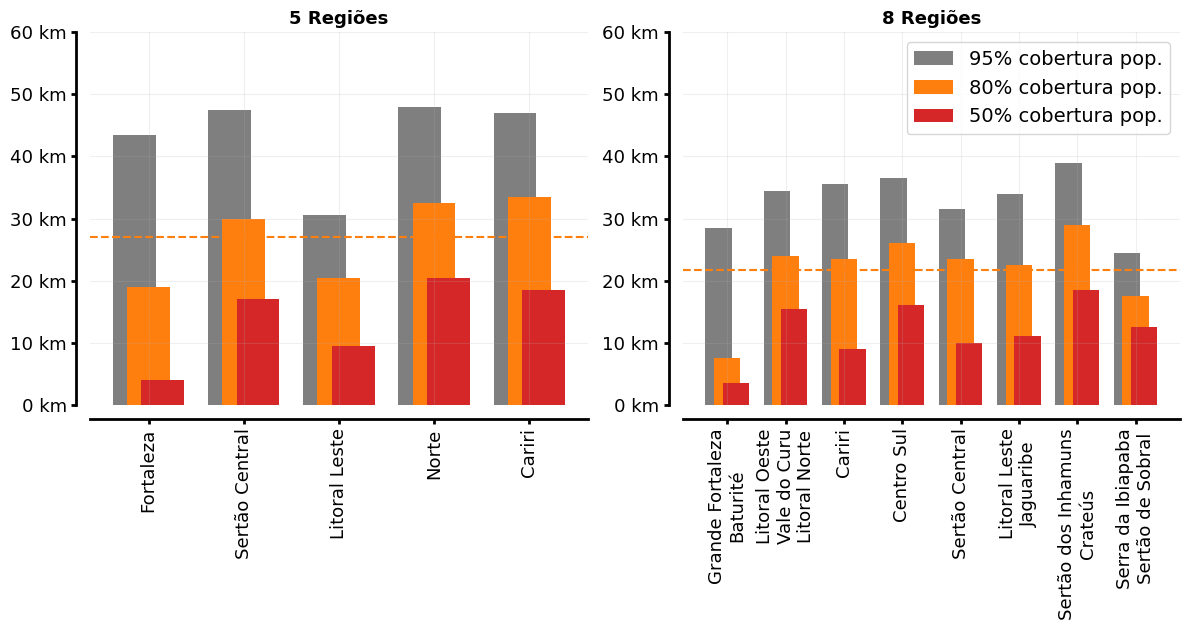

In [24]:
aux = geodata_df1.drop_duplicates(subset=["NOME_REGIAO_ORIGINAL"])[["MACRO_ID", "NOME_REGIAO_ORIGINAL"]]
aux["NOME_REGIAO_ORIGINAL"] = aux["NOME_REGIAO_ORIGINAL"].apply(lambda x: x.replace("Superintendência Regional de Saúde ", ""))
aux = dict(zip(aux["MACRO_ID"], aux["NOME_REGIAO_ORIGINAL"]))

aux_prop = geodata_df1.drop_duplicates(subset=["NOME_REGIAO_SAUDE_8"])[["REGIAO_SAUDE_8", "NOME_REGIAO_SAUDE_8"]]
aux_prop["NOME_REGIAO_SAUDE_8"] = aux_prop["NOME_REGIAO_SAUDE_8"].apply(lambda x: x.replace("Superintendência Regional de Saúde ", ""))
aux_prop = dict(zip(aux_prop["REGIAO_SAUDE_8"], aux_prop["NOME_REGIAO_SAUDE_8"]))

fig, (AX1, AX2) = plt.subplots(1,2, figsize=(12,6.4))

mean80 = np.mean([ elem[2]['80%'] for elem in lst_cumsum ])
mean80prop = np.mean([ elem[2]['80%'] for elem in lst_cumsum_prop ])

#AX1.plot([ elem[0] for elem in lst_cumsum ], [ elem[3]['99%'] for elem in lst_cumsum ], label="99% cobertura pop.", ls=":", marker="o", ms=1, color="tab:gray")
AX1.bar([ elem[0]-0.15 for elem in lst_cumsum ], [ elem[3]['95%'] for elem in lst_cumsum ], label="95% cobertura pop.", color="tab:gray", width=0.45)
#AX1.plot([ elem[0] for elem in lst_cumsum ], [ elem[2]['80%'] for elem in lst_cumsum ], label="80% cobertura pop.", ls=":", marker="o", ms=1, color="tab:orange")
AX1.bar([ elem[0] for elem in lst_cumsum ], [ elem[2]['80%'] for elem in lst_cumsum ], label="80% cobertura pop.", color="tab:orange", width=0.45)
#AX1.plot([ elem[0] for elem in lst_cumsum ], [ elem[1]['50%'] for elem in lst_cumsum ], label="50% cobertura pop.", ls=":", marker="s", ms=1, color="tab:red")
AX1.bar([ elem[0]+0.15 for elem in lst_cumsum ], [ elem[1]['50%'] for elem in lst_cumsum ], label="50% cobertura pop.", color="tab:red", width=0.45)

#AX2.plot([ elem[0] for elem in lst_cumsum_prop ], [ elem[3]['95%'] for elem in lst_cumsum_prop ], ls="", marker="^", ms=9, color="tab:gray")
AX2.bar([ elem[0]-0.15 for elem in lst_cumsum_prop ], [ elem[3]['95%'] for elem in lst_cumsum_prop ], label="95% cobertura pop.", color="tab:gray", width=0.45)
#AX2.plot([ elem[0] for elem in lst_cumsum_prop ], [ elem[2]['80%'] for elem in lst_cumsum_prop ], label="80% cobertura pop.", ls="", marker="o", ms=9, color="tab:orange")
AX2.bar([ elem[0] for elem in lst_cumsum_prop ], [ elem[2]['80%'] for elem in lst_cumsum_prop ], label="80% cobertura pop.", color="tab:orange", width=0.45)
#AX2.plot([ elem[0] for elem in lst_cumsum_prop ], [ elem[1]['50%'] for elem in lst_cumsum_prop ], label="50% cobertura pop.", ls="", marker="s", ms=9, color="tab:red")
AX2.bar([ elem[0]+0.15 for elem in lst_cumsum_prop ], [ elem[1]['50%'] for elem in lst_cumsum_prop ], label="50% cobertura pop.", color="tab:red", width=0.45)


for AX in [AX1, AX2]:
    AX.grid(alpha=0.2, zorder=0)
    for sp in ['left', 'right', 'bottom', 'top']:
        AX.spines[sp].set_linewidth(2)
        AX.spines[sp].set_position(('outward', 10))
    AX.spines['right'].set_linewidth(0)
    AX.spines['top'].set_linewidth(0)
    AX.tick_params(width=2)

    #AX.set_xticks([n for n in bins[:-1]])
    #AX.set_xticklabels([ f'{x:0.0f} km' if x%10==0 else '' for x in bins[:-1] ])
    AX.set_ylim([0,60])
    AX.set_yticklabels([ f'{float(y.get_text()):.0f} km' for y in AX.get_yticklabels() ])
    #AX.set_xlim([0,70])
    
    #AX.text(x=10, y=0.81, s='80%', fontsize=11, weight='bold', ha='center', color='#4d4d4d')
    #AX.text(x=10, y=0.51, s='50%', fontsize=11, weight='bold', ha='center', color='#4d4d4d')
    #AX.set_xlabel("Distância geodésica (KM)", fontsize=11, weight='bold')
    AX.xaxis.set_tick_params(labelsize=13)
    AX.yaxis.set_tick_params(labelsize=13)


AX1.axhline(y=mean80, color="tab:orange", lw=1.5, ls="--")
AX2.axhline(y=mean80prop, color="tab:orange", lw=1.5, ls="--")
AX2.legend(prop={'size': 14,})
AX1.set_xticks([1,2,3,4,5])
AX2.set_xticks([1,2,3,4,5,6,7,8])
AX1.set_xticklabels([ aux[int(x.get_text())] for x in AX1.get_xticklabels() ], rotation=90)
AX2.set_xticklabels([ aux_prop[int(x.get_text())] for x in AX2.get_xticklabels() ], rotation=90)
AX1.set_title("5 Regiões", fontsize=13, weight='bold')
AX2.set_title("8 Regiões", fontsize=13, weight='bold')

fig.tight_layout()
#fig.savefig(basepath.joinpath("redes_aih", "doc_final", "distancia_macros.png"), dpi=250, bbox_inches='tight')

C:\Users\higor.monteiro\AppData\Local\Temp\ipykernel_20640\75756322.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  AX.set_yticklabels([ f'{float(y.get_text()):.0f} km' for y in AX.get_yticklabels() ])


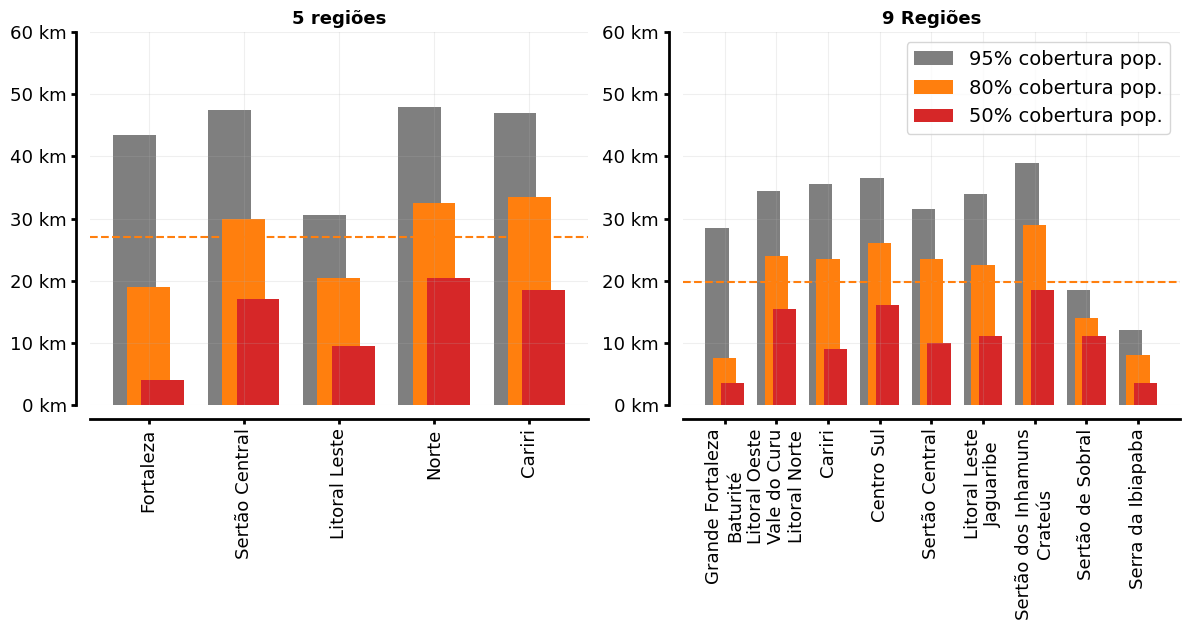

In [25]:
aux = geodata_df1.drop_duplicates(subset=["NOME_REGIAO_ORIGINAL"])[["MACRO_ID", "NOME_REGIAO_ORIGINAL"]]
aux["NOME_REGIAO_ORIGINAL"] = aux["NOME_REGIAO_ORIGINAL"].apply(lambda x: x.replace("Superintendência Regional de Saúde ", ""))
aux = dict(zip(aux["MACRO_ID"], aux["NOME_REGIAO_ORIGINAL"]))

aux_prop = geodata_df1.drop_duplicates(subset=["NOME_REGIAO_SAUDE_9"])[["REGIAO_SAUDE_9", "NOME_REGIAO_SAUDE_9"]]
aux_prop["NOME_REGIAO_SAUDE_9"] = aux_prop["NOME_REGIAO_SAUDE_9"].apply(lambda x: x.replace("Superintendência Regional de Saúde ", ""))
aux_prop = dict(zip(aux_prop["REGIAO_SAUDE_9"], aux_prop["NOME_REGIAO_SAUDE_9"]))

fig, (AX1, AX2) = plt.subplots(1,2, figsize=(12,6.4))

mean80 = np.mean([ elem[2]['80%'] for elem in lst_cumsum ])
mean80prop = np.mean([ elem[2]['80%'] for elem in lst_cumsum_prop9 ])

#AX1.plot([ elem[0] for elem in lst_cumsum ], [ elem[3]['99%'] for elem in lst_cumsum ], label="99% cobertura pop.", ls=":", marker="o", ms=1, color="tab:gray")
AX1.bar([ elem[0]-0.15 for elem in lst_cumsum ], [ elem[3]['95%'] for elem in lst_cumsum ], label="95% cobertura pop.", color="tab:gray", width=0.45)
#AX1.plot([ elem[0] for elem in lst_cumsum ], [ elem[2]['80%'] for elem in lst_cumsum ], label="80% cobertura pop.", ls=":", marker="o", ms=1, color="tab:orange")
AX1.bar([ elem[0] for elem in lst_cumsum ], [ elem[2]['80%'] for elem in lst_cumsum ], label="80% cobertura pop.", color="tab:orange", width=0.45)
#AX1.plot([ elem[0] for elem in lst_cumsum ], [ elem[1]['50%'] for elem in lst_cumsum ], label="50% cobertura pop.", ls=":", marker="s", ms=1, color="tab:red")
AX1.bar([ elem[0]+0.15 for elem in lst_cumsum ], [ elem[1]['50%'] for elem in lst_cumsum ], label="50% cobertura pop.", color="tab:red", width=0.45)

#AX2.plot([ elem[0] for elem in lst_cumsum_prop ], [ elem[3]['95%'] for elem in lst_cumsum_prop ], ls="", marker="^", ms=9, color="tab:gray")
AX2.bar([ elem[0]-0.15 for elem in lst_cumsum_prop9 ], [ elem[3]['95%'] for elem in lst_cumsum_prop9 ], label="95% cobertura pop.", color="tab:gray", width=0.45)
#AX2.plot([ elem[0] for elem in lst_cumsum_prop9 ], [ elem[2]['80%'] for elem in lst_cumsum_prop9 ], label="80% cobertura pop.", ls="", marker="o", ms=9, color="tab:orange")
AX2.bar([ elem[0] for elem in lst_cumsum_prop9 ], [ elem[2]['80%'] for elem in lst_cumsum_prop9 ], label="80% cobertura pop.", color="tab:orange", width=0.45)
#AX2.plot([ elem[0] for elem in lst_cumsum_prop9 ], [ elem[1]['50%'] for elem in lst_cumsum_prop9 ], label="50% cobertura pop.", ls="", marker="s", ms=9, color="tab:red")
AX2.bar([ elem[0]+0.15 for elem in lst_cumsum_prop9 ], [ elem[1]['50%'] for elem in lst_cumsum_prop9 ], label="50% cobertura pop.", color="tab:red", width=0.45)


for AX in [AX1, AX2]:
    AX.grid(alpha=0.2, zorder=0)
    for sp in ['left', 'right', 'bottom', 'top']:
        AX.spines[sp].set_linewidth(2)
        AX.spines[sp].set_position(('outward', 10))
    AX.spines['right'].set_linewidth(0)
    AX.spines['top'].set_linewidth(0)
    AX.tick_params(width=2)

    #AX.set_xticks([n for n in bins[:-1]])
    #AX.set_xticklabels([ f'{x:0.0f} km' if x%10==0 else '' for x in bins[:-1] ])
    AX.set_ylim([0,60])
    AX.set_yticklabels([ f'{float(y.get_text()):.0f} km' for y in AX.get_yticklabels() ])
    #AX.set_xlim([0,70])
    
    #AX.text(x=10, y=0.81, s='80%', fontsize=11, weight='bold', ha='center', color='#4d4d4d')
    #AX.text(x=10, y=0.51, s='50%', fontsize=11, weight='bold', ha='center', color='#4d4d4d')
    #AX.set_xlabel("Distância geodésica (KM)", fontsize=11, weight='bold')
    AX.xaxis.set_tick_params(labelsize=13)
    AX.yaxis.set_tick_params(labelsize=13)

AX1.axhline(y=mean80, color="tab:orange", lw=1.5, ls="--")
AX2.axhline(y=mean80prop, color="tab:orange", lw=1.5, ls="--")
AX2.legend(prop={'size': 14,})
AX1.set_xticks([1,2,3,4,5])
AX2.set_xticks([1,2,3,4,5,6,7,8,9])
AX1.set_xticklabels([ aux[int(x.get_text())] for x in AX1.get_xticklabels() ], rotation=90)
AX2.set_xticklabels([ aux_prop[int(x.get_text())] for x in AX2.get_xticklabels() ], rotation=90)
AX1.set_title("5 regiões", fontsize=13, weight='bold')
AX2.set_title("9 Regiões", fontsize=13, weight='bold')

fig.tight_layout()
#fig.savefig(basepath.joinpath("redes_aih", "doc_final", "distancia_macros.png"), dpi=250, bbox_inches='tight')

C:\Users\higor.monteiro\AppData\Local\Temp\ipykernel_20640\3879304338.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  AX.set_yticklabels([ f'{float(y.get_text()):.0f} km' for y in AX.get_yticklabels() ])


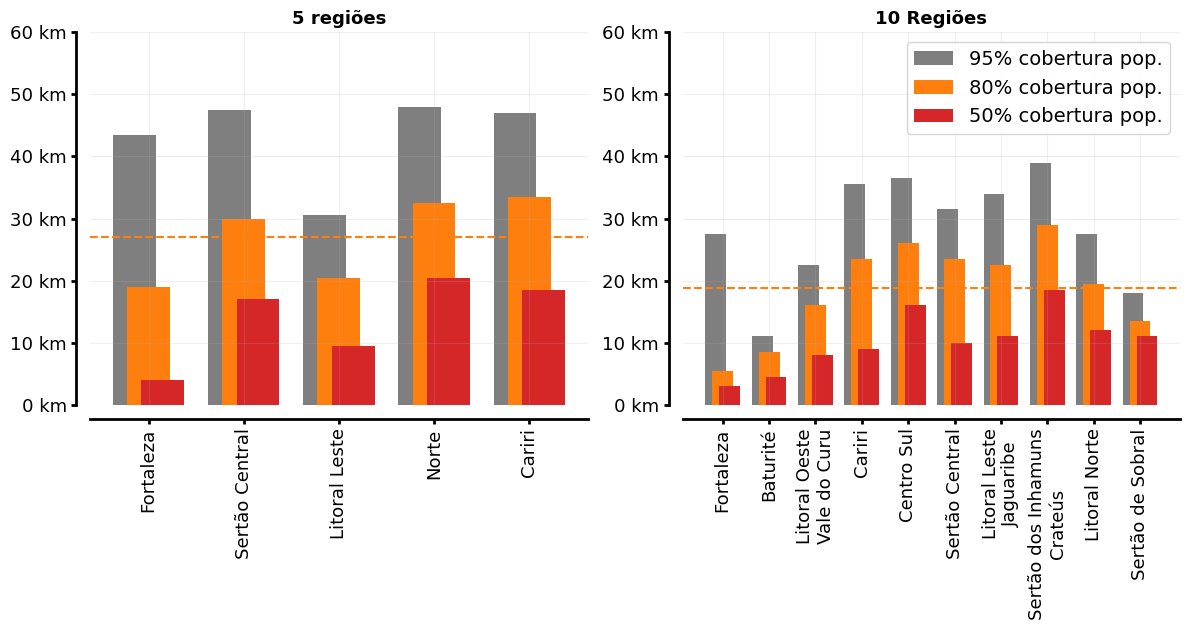

In [26]:
aux = geodata_df1.drop_duplicates(subset=["NOME_REGIAO_ORIGINAL"])[["MACRO_ID", "NOME_REGIAO_ORIGINAL"]]
aux["NOME_REGIAO_ORIGINAL"] = aux["NOME_REGIAO_ORIGINAL"].apply(lambda x: x.replace("Superintendência Regional de Saúde ", ""))
aux = dict(zip(aux["MACRO_ID"], aux["NOME_REGIAO_ORIGINAL"]))

aux_prop = geodata_df1.drop_duplicates(subset=["NOME_REGIAO_SAUDE_10"])[["REGIAO_SAUDE_10", "NOME_REGIAO_SAUDE_10"]]
aux_prop["NOME_REGIAO_SAUDE_10"] = aux_prop["NOME_REGIAO_SAUDE_10"].apply(lambda x: x.replace("Superintendência Regional de Saúde ", ""))
aux_prop = dict(zip(aux_prop["REGIAO_SAUDE_10"], aux_prop["NOME_REGIAO_SAUDE_10"]))

fig, (AX1, AX2) = plt.subplots(1,2, figsize=(12,6.4))

mean80 = np.mean([ elem[2]['80%'] for elem in lst_cumsum ])
mean80prop = np.mean([ elem[2]['80%'] for elem in lst_cumsum_prop10 ])

#AX1.plot([ elem[0] for elem in lst_cumsum ], [ elem[3]['99%'] for elem in lst_cumsum ], label="99% cobertura pop.", ls=":", marker="o", ms=1, color="tab:gray")
AX1.bar([ elem[0]-0.15 for elem in lst_cumsum ], [ elem[3]['95%'] for elem in lst_cumsum ], label="95% cobertura pop.", color="tab:gray", width=0.45)
#AX1.plot([ elem[0] for elem in lst_cumsum ], [ elem[2]['80%'] for elem in lst_cumsum ], label="80% cobertura pop.", ls=":", marker="o", ms=1, color="tab:orange")
AX1.bar([ elem[0] for elem in lst_cumsum ], [ elem[2]['80%'] for elem in lst_cumsum ], label="80% cobertura pop.", color="tab:orange", width=0.45)
#AX1.plot([ elem[0] for elem in lst_cumsum ], [ elem[1]['50%'] for elem in lst_cumsum ], label="50% cobertura pop.", ls=":", marker="s", ms=1, color="tab:red")
AX1.bar([ elem[0]+0.15 for elem in lst_cumsum ], [ elem[1]['50%'] for elem in lst_cumsum ], label="50% cobertura pop.", color="tab:red", width=0.45)

#AX2.plot([ elem[0] for elem in lst_cumsum_prop ], [ elem[3]['95%'] for elem in lst_cumsum_prop ], ls="", marker="^", ms=9, color="tab:gray")
AX2.bar([ elem[0]-0.15 for elem in lst_cumsum_prop10 ], [ elem[3]['95%'] for elem in lst_cumsum_prop10 ], label="95% cobertura pop.", color="tab:gray", width=0.45)
#AX2.plot([ elem[0] for elem in lst_cumsum_prop10 ], [ elem[2]['80%'] for elem in lst_cumsum_prop10 ], label="80% cobertura pop.", ls="", marker="o", ms=9, color="tab:orange")
AX2.bar([ elem[0] for elem in lst_cumsum_prop10 ], [ elem[2]['80%'] for elem in lst_cumsum_prop10 ], label="80% cobertura pop.", color="tab:orange", width=0.45)
#AX2.plot([ elem[0] for elem in lst_cumsum_prop10 ], [ elem[1]['50%'] for elem in lst_cumsum_prop10 ], label="50% cobertura pop.", ls="", marker="s", ms=9, color="tab:red")
AX2.bar([ elem[0]+0.15 for elem in lst_cumsum_prop10 ], [ elem[1]['50%'] for elem in lst_cumsum_prop10 ], label="50% cobertura pop.", color="tab:red", width=0.45)


for AX in [AX1, AX2]:
    AX.grid(alpha=0.2, zorder=0)
    for sp in ['left', 'right', 'bottom', 'top']:
        AX.spines[sp].set_linewidth(2)
        AX.spines[sp].set_position(('outward', 10))
    AX.spines['right'].set_linewidth(0)
    AX.spines['top'].set_linewidth(0)
    AX.tick_params(width=2)

    #AX.set_xticks([n for n in bins[:-1]])
    #AX.set_xticklabels([ f'{x:0.0f} km' if x%10==0 else '' for x in bins[:-1] ])
    AX.set_ylim([0,60])
    AX.set_yticklabels([ f'{float(y.get_text()):.0f} km' for y in AX.get_yticklabels() ])
    #AX.set_xlim([0,70])
    
    #AX.text(x=10, y=0.81, s='80%', fontsize=11, weight='bold', ha='center', color='#4d4d4d')
    #AX.text(x=10, y=0.51, s='50%', fontsize=11, weight='bold', ha='center', color='#4d4d4d')
    #AX.set_xlabel("Distância geodésica (KM)", fontsize=11, weight='bold')
    AX.xaxis.set_tick_params(labelsize=13)
    AX.yaxis.set_tick_params(labelsize=13)

AX1.axhline(y=mean80, color="tab:orange", lw=1.5, ls="--")
AX2.axhline(y=mean80prop, color="tab:orange", lw=1.5, ls="--")
AX2.legend(prop={'size': 14,})
AX1.set_xticks([1,2,3,4,5])
AX2.set_xticks([1,2,3,4,5,6,7,8,9,10])
AX1.set_xticklabels([ aux[int(x.get_text())] for x in AX1.get_xticklabels() ], rotation=90)
AX2.set_xticklabels([ aux_prop[int(x.get_text())] for x in AX2.get_xticklabels() ], rotation=90)
AX1.set_title("5 regiões", fontsize=13, weight='bold')
AX2.set_title("10 Regiões", fontsize=13, weight='bold')

fig.tight_layout()
#fig.savefig(basepath.joinpath("redes_aih", "doc_final", "distancia_macros.png"), dpi=250, bbox_inches='tight')

In [ ]:
def